# 82 Octet Binary Dataset

In [308]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [309]:
def round_array_to_binary(arr, threshold=0.5):
    arr = np.array(arr)  # Convert input to NumPy array if it's not already
    return np.where(arr >= threshold, 1, 0)

In [310]:
octet = pd.read_csv('octet.csv')
octet_selected = octet[['rp(A)', 'rp(B)', 'rs(A)']]
# octet_selected['sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']
octet_sel = pd.DataFrame()
octet_sel.loc[:, 'sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']
octet_selected = pd.concat([octet_sel, octet_selected], axis=1)
# octet_selected = octet_selected.to_numpy()

In [311]:
octet_selected.loc[(octet_selected['sigma']>=0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=-0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=1.16) & (octet_selected['sigma']>=-1.16) & (octet_selected['rs(A)'] <=1.27), 'RS_ZB'] = -1 
octet_selected.loc[octet_selected['RS_ZB'].isnull(), 'RS_ZB'] = 0

octet_selected.loc[(octet_selected['sigma']>=0.91), 'sigma>0.91'] = 1
octet_selected.loc[octet_selected['sigma>0.91'].isnull(), 'sigma>0.91'] = 0

octet_selected.loc[(octet_selected['sigma']<=-0.91), 'sigma<-0.91'] = 1 
octet_selected.loc[octet_selected['sigma<-0.91'].isnull(), 'sigma<-0.91'] = 0

octet_selected.loc[(octet_selected['rs(A)']>=1.22), 'rs>1.22'] = 1 
octet_selected.loc[octet_selected['rs>1.22'].isnull(), 'rs>1.22'] = 0

octet_selected.loc[(octet_selected['sigma']<=1.16), 'sigma<1.16'] = 1 
octet_selected.loc[octet_selected['sigma<1.16'].isnull(), 'sigma<1.16'] = 0

octet_selected.loc[(octet_selected['sigma']>=-1.16), 'sigma>-1.16'] = 1 
octet_selected.loc[octet_selected['sigma>-1.16'].isnull(), 'sigma>-1.16'] = 0

octet_selected.loc[(octet_selected['rs(A)']<=1.27), 'rs<1.27'] = 1 
octet_selected.loc[octet_selected['rs<1.27'].isnull(), 'rs<1.27'] = 0

In [312]:
second_layer_data = octet_selected[['sigma>0.91', 'sigma<-0.91', 'sigma<1.16', 'sigma>-1.16', 'rs>1.22','rs<1.27', 'RS_ZB']]
X = octet_selected[['sigma>0.91', 'sigma<-0.91', 'sigma<1.16', 'sigma>-1.16', 'rs>1.22','rs<1.27']].to_numpy()
y = octet_selected['RS_ZB'].to_numpy()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
RNG = np.random.default_rng(seed=0)
train_ind = RNG.choice(len(X), size=int(len(X)*0.80), replace=False)
test_ind = np.setdiff1d(np.array(range(len(X))), train_ind)
X_train, X_test, y_train, y_test = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

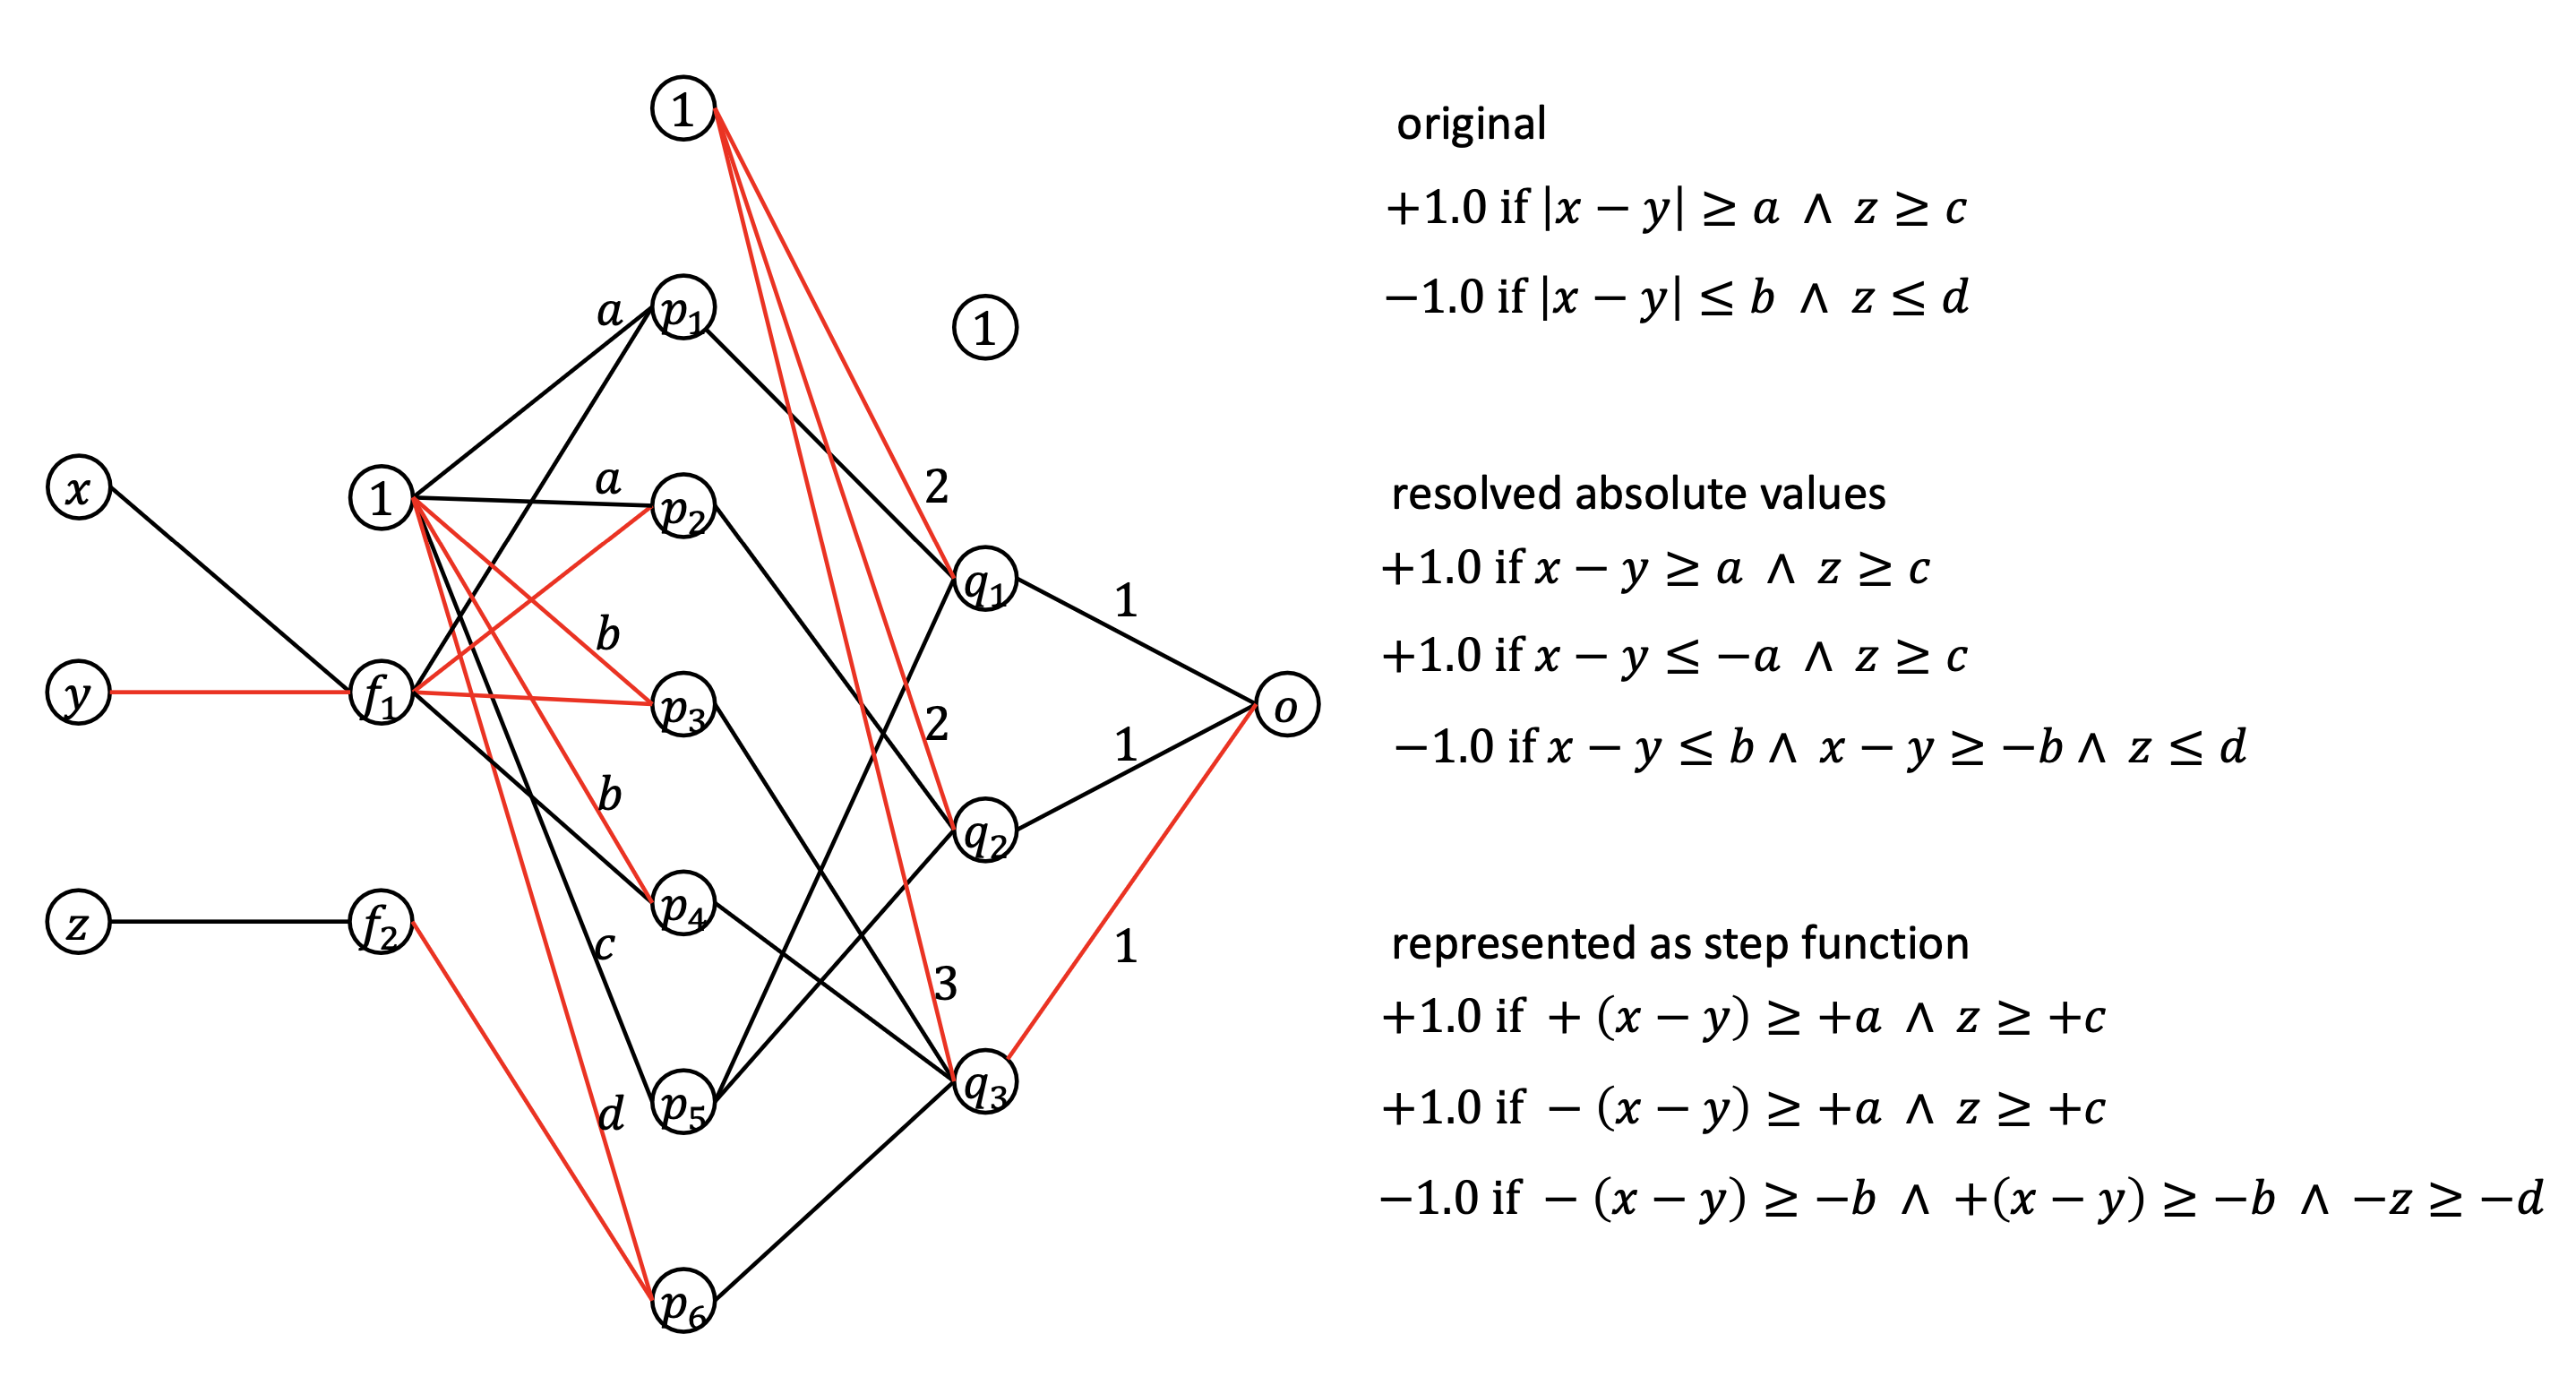

In [313]:
from IPython import display
display.Image("OctetBinary.png")

# Loading Dataset and Transform to Tensor

In [340]:
class OctetBinary(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.n_samples = X.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    
dataset = OctetBinary(X_train, y_train)
dataloader = DataLoader(dataset=dataset, batch_size=int(0.4*len(X_train)), shuffle=True)

# dataset = TensorDataset(X, y)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Creating the NN Model

In [315]:
class StepActivation(nn.Module):
    def forward(self, x):
        return torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))

class BinaryRounding(nn.Module):
    def forward(self, x):
        return torch.where(x >= 0.5, torch.tensor(1.0), torch.tensor(0.0))

class SigmoidMinusOneActivation(torch.nn.Module):
    def forward(self, x):
        return torch.sigmoid(x) - 1


class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, alpha, idealmodel=False):
        super(RegressionModel, self).__init__()
        # Define the hidden layer with sigmoid activation
        self.hidden = nn.Sequential(
            nn.Linear(input_size, hidden_size, bias=True),
            # nn.Tanh()
            nn.Sigmoid()
            # ,BinaryRounding()
            # ,StepActivation()
            # ,SigmoidMinusOneActivation()
        )

        # Define the output layer with one node (for regression)
        self.output = nn.Linear(hidden_size, output_size, bias=False)

        # Ground truth weights
        if idealmodel:
            with torch.no_grad():
                hidden_weights = torch.tensor([[1,0,0,0,1,0],[0,1,0,0,1,0],[0,0,1,1,0,1]], dtype=torch.float32)
                self.hidden[0].weight.data = hidden_weights.clone()
                sum_of_weights_hidden = -self.hidden[0].weight.sum(dim=1)
                self.hidden[0].bias.data = sum_of_weights_hidden.clone()

                output_weights = torch.tensor([[1,1,-1]], dtype=torch.float32)
                self.output.weight.data = output_weights.clone()
                # sum_of_weights_output = -self.output.weight.sum()
                # self.output.bias.data.fill_(sum_of_weights_output)
        
        self.alpha = alpha
    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        # x = torch.tanh(self.output(x))
        return x

    def l1_loss(self):
        l1_loss = 0.0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return self.alpha * l1_loss
    
    def binary_loss(self):
        binary_loss = 0.0
        w_ = []
        for name, param in self.named_parameters():
            if name == 'hidden.0.weight':
                w_.append(param.reshape(-1,1))
            
        for v in w_:
            for v_i in v:
                if torch.abs(v_i) < torch.abs(v_i-1):
                    b = 0
                else:
                    b = 1
                binary_loss += torch.sum(torch.tensor(b))
        return self.alpha * binary_loss
    
    
    def round_parameters(self):
        for name, param in self.named_parameters():
            if name != 'output.weight':
                param.data = torch.where(param.data >= 0.5, torch.tensor(1.0), torch.tensor(0.0)) #BinaryRounding.forward(param.data).clone().detach().requires_grad_(True)
            if name == 'output.weight':
                param.data = torch.round(param.data).clone().detach().requires_grad_(True)

    
    def predict(self, input):
        self.eval()
        input = torch.tensor(input, dtype=torch.float32)

        with torch.no_grad():
            output = self.forward(input)

        self.train()
        
        return output.numpy()
    

In [316]:
input_size = 6
hidden_size = 3
output_size = 1
alpha = 0.0001

model_ideal = RegressionModel(input_size, hidden_size, output_size, alpha=alpha, idealmodel=True)
for name, param in model_ideal.named_parameters():
    print(name, param)

y_prediction_groundtruth = model_ideal.predict(X)

hidden.0.weight Parameter containing:
tensor([[1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0., 1.]], requires_grad=True)
hidden.0.bias Parameter containing:
tensor([-2., -2., -3.], requires_grad=True)
output.weight Parameter containing:
tensor([[ 1.,  1., -1.]], requires_grad=True)


MSE for ideal NN is: 1.1850324908778342


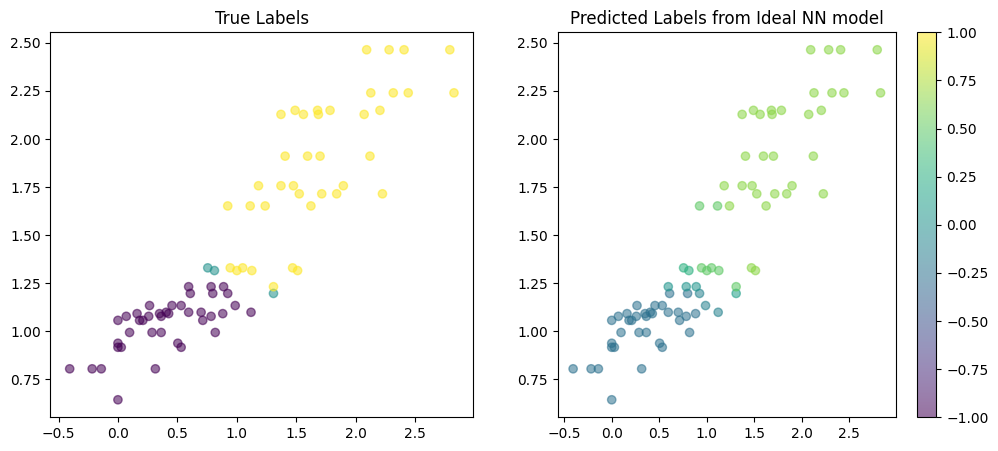

In [317]:
np.random.seed(19680801)
yaxis = [octet_selected['RS_ZB'], y_prediction_groundtruth]
axs_title = ['True Labels', 'Predicted Labels from Ideal NN model']
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=yaxis[col], cmap='viridis', alpha = 0.55, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

fig.colorbar(pcm)

print(f'MSE for ideal NN is: {(np.mean((y-y_prediction_groundtruth)**2))}')

# Trainign the Model 

In [318]:
model = RegressionModel(input_size, hidden_size, output_size, alpha=alpha, idealmodel=False)
loss_criterion = nn.MSELoss()
average_epoch_loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        predictions = model(batch_x)  
        # mse_loss = loss_criterion(predictions, batch_y) # for regression
        mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) # for logistic
        lasso_loss = model.l1_loss() 
        binary_loss = model.binary_loss()
        total_loss = mse_loss #+ binary_loss # Total loss (MSE + if regularization)
        total_loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        # model.round_parameters()
        # model.set_bias()
        epoch_loss += total_loss.item()
    
    # Calculate and print average loss for the epoch
    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list.append(average_epoch_loss)
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')



Epoch [1/10000] Loss: 0.8290
Epoch [1001/10000] Loss: 0.0087
Epoch [2001/10000] Loss: 0.0067
Epoch [3001/10000] Loss: 0.0056
Epoch [4001/10000] Loss: 0.0031
Epoch [5001/10000] Loss: 0.0019
Epoch [6001/10000] Loss: 0.0010
Epoch [7001/10000] Loss: 0.0005
Epoch [8001/10000] Loss: 0.0003
Epoch [9001/10000] Loss: 0.0005


# Plots and Results

Text(0, 0.5, '(MSE + Regul.)/batch_size')

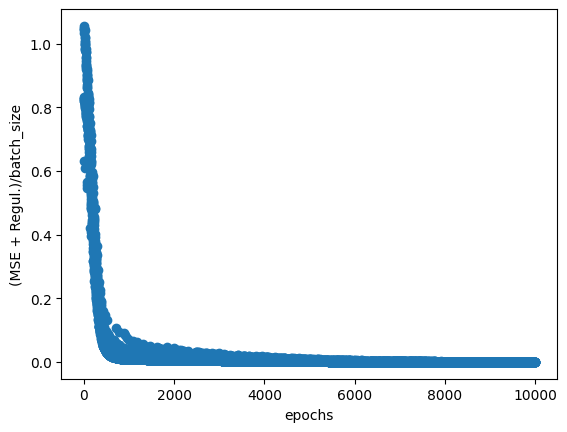

In [319]:
plt.scatter(range(num_epochs), average_epoch_loss_list)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

In [320]:
weights = []
for name, param in model.named_parameters():
    weights.append(param.detach().numpy())
    print(name, param)

hidden.0.weight Parameter containing:
tensor([[-4.1730, -0.0770,  4.2370,  0.1548, -4.1313,  4.1967],
        [ 2.2662, -0.3886, -1.9860, -0.2881,  2.8234, -2.6279],
        [ 4.1421, -0.3743, -4.0644, -0.0482,  4.1804, -4.1131]],
       requires_grad=True)
hidden.0.bias Parameter containing:
tensor([-0.2371, -0.1637, -0.0803], requires_grad=True)
output.weight Parameter containing:
tensor([[-1.0034, -0.0241,  1.0254]], requires_grad=True)


In [321]:
y_pred = model.predict(X_test)
y_test = y_test.reshape(-1,1)
print(f'MSE for unrounded parameters is: {(np.mean((y_test-y_pred)**2))}')

MSE for unrounded parameters is: 0.00022524488884807382


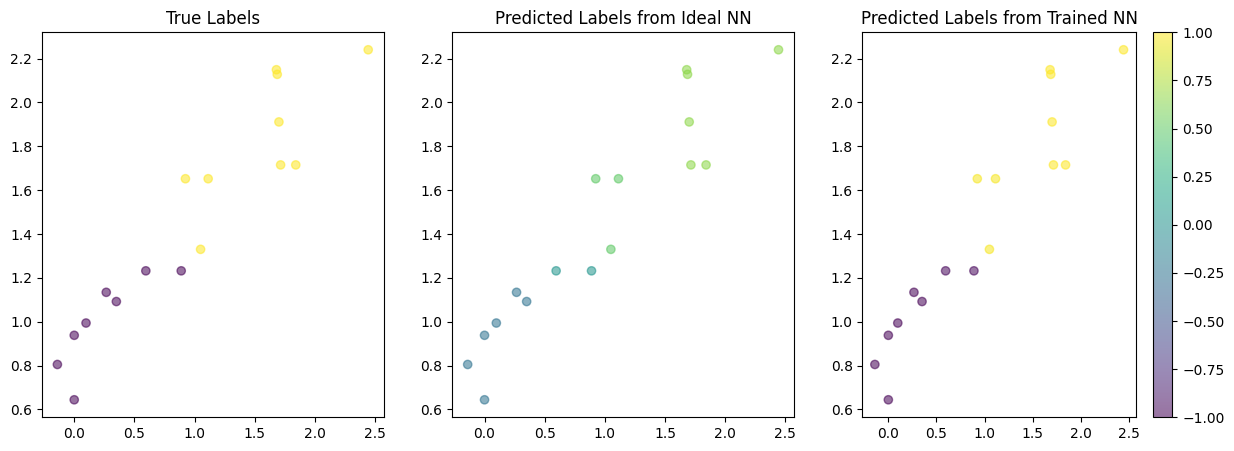

In [322]:
np.random.seed(19680801)
yaxis = [y_test, y_prediction_groundtruth[test_ind], y_pred]
axs_title = ['True Labels', 'Predicted Labels from Ideal NN', 'Predicted Labels from Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for col in range(3):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'][test_ind],octet_selected['rs(A)'][test_ind], c=yaxis[col], cmap='viridis',  alpha=0.55, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

# fig.suptitle('Prediction over Test Points')
fig.colorbar(pcm)


In [323]:
def loss_criterion(y_true, y_pred, binary_penalty=False, alpha=0.001, w=None):
    y_true = torch.tensor(y_true, dtype=torch.float32)
    y_pred = torch.tensor(y_pred, dtype=torch.float32)
    mse_loss = torch.sum((y_true-y_pred)**2)/(2*len(y_true))
    binary_loss = 0.0
    total_loss = mse_loss
    if binary_penalty:
        for v in w:
            for v_i in v:
                if torch.abs(v_i) < torch.abs(v_i-1):
                    b = 0
                else:
                    b = 1
                binary_loss += torch.sum(torch.tensor(b))
        total_loss = mse_loss + alpha * binary_loss

    return total_loss

In [415]:
class BinaryNNModel():
    def __init__(self, input_size, hidden_size, output_size, bias=False, ideal_model=False):
        self.bias = bias
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        if ideal_model:
            self.prop_weights = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1], [1, 1, 0], [0, 0, 1]], dtype=torch.float32, requires_grad=True)
            self.con_weights = torch.tensor([[1], [1], [-1]], dtype=torch.float32, requires_grad=True)
            self.prop_bias = -self.prop_weights.sum(dim=0)
        else:
            self.prop_weights = torch.where(torch.randn(input_size, hidden_size, requires_grad=True)>=0.5, torch.tensor(1.0), torch.tensor(0.0))
            if self.bias:
                self.prop_bias = -self.prop_weights.sum(dim=0)
            self.con_weights = torch.where(torch.randn(hidden_size, output_size, requires_grad=True)>=0, torch.tensor(1.0), torch.tensor(-1.0))
        # self.fc2_bias = torch.zeros(output_size)

    def forward(self, x):
        self.prop_weights = torch.where(self.prop_weights>=0.5, torch.tensor(1.0), torch.tensor(0.0))
        if self.bias:
            self.prop_bias = -self.prop_weights.sum(dim=0)
            x = torch.mm(x, self.prop_weights) + self.prop_bias
        else:
            x = torch.mm(x, self.prop_weights)
        x = torch.nn.functional.sigmoid(x)
        self.con_weights = torch.where(self.con_weights>=0.0, torch.tensor(1.0), torch.tensor(-1.0))
        # x = BinaryRounding()(x)
        x = torch.mm(x, self.con_weights) #+ self.fc2_bias
        return x

        
    def predict(self, input):
        input = torch.tensor(input, dtype=torch.float32)
        with torch.no_grad():
            output = self.forward(input)
        
        return output.numpy()
    

In [416]:
input_size = 6
hidden_size = 3
output_size = 1
model1_ideal = BinaryNNModel(input_size, hidden_size, output_size, bias=True, ideal_model=True)
y_model1_ideal = model1_ideal.predict(X)

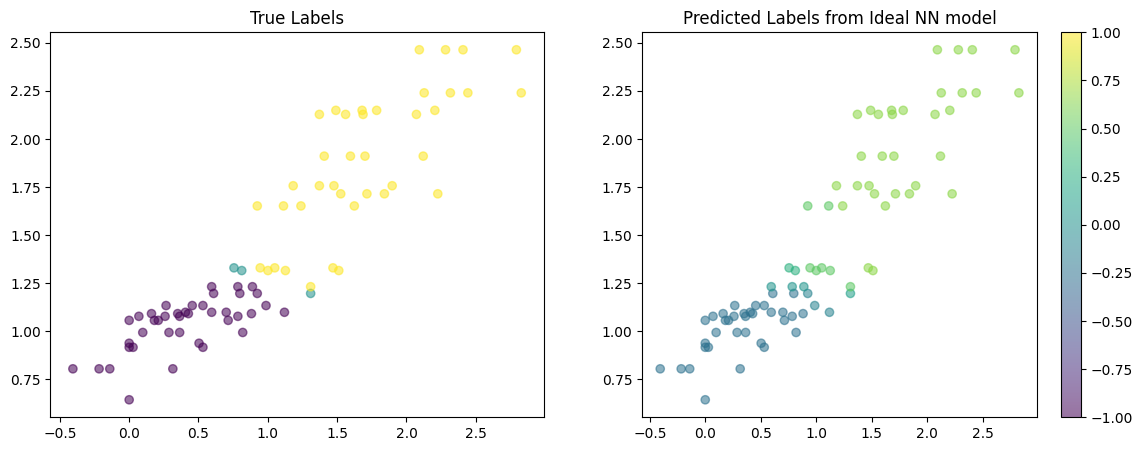

In [417]:
np.random.seed(19680801)
yaxis = [octet_selected['RS_ZB'], y_model1_ideal]
axs_title = ['True Labels', 'Predicted Labels from Ideal NN model']
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=yaxis[col], cmap='viridis', alpha = 0.55, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

fig.colorbar(pcm)

In [418]:
alpha = 0.01
loss_criterion(y, y_model1_ideal, binary_penalty=False, w=None, alpha=alpha)
model1 = BinaryNNModel(input_size, hidden_size, output_size, bias=True, ideal_model=False)
print(f'Proposition Weights: {model1.prop_weights}')
print(f'Proposition Bias: {model1.prop_bias}')
print(f'Conjuction Weights: {model1.con_weights}')

Proposition Weights: tensor([[0., 1., 0.],
        [0., 1., 1.],
        [1., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
Proposition Bias: tensor([-2., -4., -2.])
Conjuction Weights: tensor([[-1.],
        [ 1.],
        [-1.]])


In [419]:
lr = 0.001
average_epoch_loss_list = []
num_epochs = 50000
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.float()
        predictions = model1.forward(batch_x)
        loss = loss_criterion(predictions, batch_y)
        z1 = torch.mm(batch_x-1, model1.prop_weights)
        q = torch.nn.functional.sigmoid(z1)
        q_d = torch.mm(q.T, q-1)
        z2 = torch.mm(q, model1.con_weights)
        delta1 = torch.mm((z2-batch_y.view(-1,1)), model1.con_weights.T) 
        delta2 = torch.mm(delta1,q_d)

        dteta = -torch.mm(q.T, (z2-batch_y.view(-1,1)))/len(batch_y)
        dw = -torch.mm(delta2.T, batch_x-1).T/len(batch_y)

        model1.con_weights = model1.con_weights + lr*dteta
        model1.prop_weights = model1.prop_weights + lr*dw

        epoch_loss += loss
    
    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list.append(average_epoch_loss)

    if epoch % 2000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

/var/folders/dy/k2n4d3yd6tx3q74wf41dj42jqt8_mj/T/ipykernel_21752/3712898210.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true, dtype=torch.float32)
/var/folders/dy/k2n4d3yd6tx3q74wf41dj42jqt8_mj/T/ipykernel_21752/3712898210.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_pred, dtype=torch.float32)


Epoch [1/50000] Loss: 13.1349
Epoch [2001/50000] Loss: 13.1844
Epoch [4001/50000] Loss: 13.2015
Epoch [6001/50000] Loss: 12.9188
Epoch [8001/50000] Loss: 13.1883
Epoch [10001/50000] Loss: 13.1789
Epoch [12001/50000] Loss: 13.2354
Epoch [14001/50000] Loss: 13.2330
Epoch [16001/50000] Loss: 13.1995
Epoch [18001/50000] Loss: 12.8156
Epoch [20001/50000] Loss: 13.1431
Epoch [22001/50000] Loss: 13.0288
Epoch [24001/50000] Loss: 13.2235
Epoch [26001/50000] Loss: 12.8179
Epoch [28001/50000] Loss: 13.0360
Epoch [30001/50000] Loss: 13.1654
Epoch [32001/50000] Loss: 12.8899
Epoch [34001/50000] Loss: 13.1230
Epoch [36001/50000] Loss: 13.0960
Epoch [38001/50000] Loss: 13.0821
Epoch [40001/50000] Loss: 13.2217
Epoch [42001/50000] Loss: 13.2181
Epoch [44001/50000] Loss: 13.2342
Epoch [46001/50000] Loss: 13.2343
Epoch [48001/50000] Loss: 13.0364


Text(0, 0.5, '(MSE + Regul.)/batch_size')

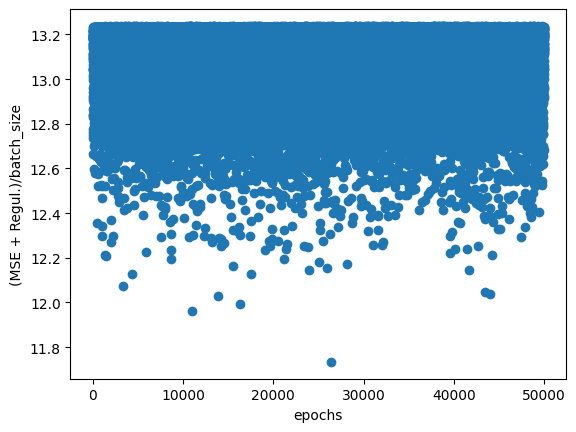

In [420]:
plt.scatter(range(num_epochs), average_epoch_loss_list)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

In [422]:
print(f'Proposition Weights: {torch.round(model1.prop_weights)}')
print(f'Proposition Bias: {model1.prop_bias}')
print(f'Conjuction Weights: {torch.round(model1.con_weights)}')

Proposition Weights: tensor([[0., 1., 0.],
        [-0., 1., 1.],
        [1., 1., -0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [-0., -0., 1.]])
Proposition Bias: tensor([-2., -4., -2.])
Conjuction Weights: tensor([[-1.],
        [ 1.],
        [-1.]])


In [423]:
y_pred_model1_test = model1.predict(X_test)
print(f'Test MSE for Model1 is: {(np.mean((y_test-y_pred_model1_test)**2))}')

y_pred_model1_train = model1.predict(X_train)
print(f'Train MSE for Model1 is: {(np.mean((y_train-y_pred_model1_train)**2))}')

Test MSE for Model1 is: 0.9318576521328652
Train MSE for Model1 is: 1.2217515520335152


In [ ]:
np.where(y_pred_model1_test>0, 1, -1)

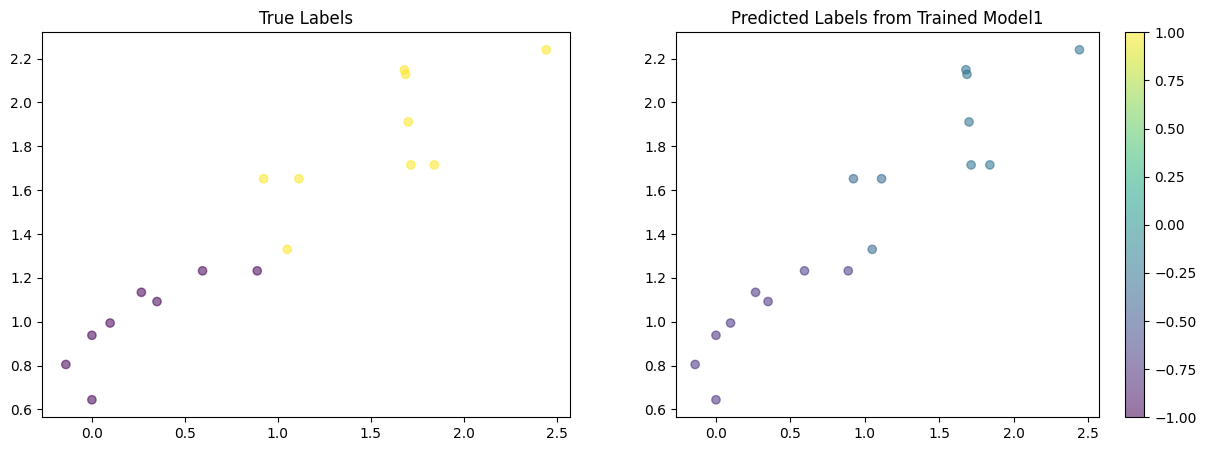

In [426]:
np.random.seed(19680801)
yaxis = [y_test, y_pred_model1_test]
axs_title = ['True Labels', 'Predicted Labels from Trained Model1']
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'][test_ind],octet_selected['rs(A)'][test_ind], c=yaxis[col], cmap='viridis',  alpha=0.55, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

# fig.suptitle('Prediction over Test Points')
fig.colorbar(pcm)